# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, we explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Our goal is to understand what factors make a car more or less expensive.  As a result of the analysis, we provide recommendations to our client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


We follow a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  

### Business Understanding

We would like to understand what features of a used car drives prices. From the dataset containing several characterestics of cars, the goal is to identify the most important features that determine car value. We will do this by first building a Machine Learning model and training it on the data. After cross-validating the model, we will extract the features that are most dominant in accurately predicting car prices.

### Data Understanding

We visualize the data in tablular form to get familiar it, as follows: 

* View the data and understand the meaning of the various features (columns) of the data
* Identify incomplete data and decide upon a reasonable apporoach to handling such data.
* Get a feel for how closely correlated the features are to each other. This will help us understand if there are redundant features which do not add significantly to data understanding. 


### Data Preparation

In [77]:
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns
import os
import random
import math

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.datasets import make_regression 
from sklearn.metrics import mean_squared_error

In [78]:
# Load the data
carsDf = pd.read_csv("data/vehicles.csv")
carsDf

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,7301591192,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,1N4AA6AV6KC367801,fwd,NaN,sedan,NaN,wy
426876,7301591187,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,7JR102FKXLG042696,fwd,NaN,sedan,red,wy
426877,7301591147,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,1GYFZFR46LF088296,NaN,NaN,hatchback,white,wy
426878,7301591140,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,58ABK1GG4JU103853,fwd,NaN,sedan,silver,wy


In [79]:
carsDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [80]:
#sns.histplot(data = carsDf, x = 'price')

### Cleanup 1:
Drop columns that are not useful characterestics for modeling. Also, drop regional data since we want to pinpoint those features that are applicable to all regions (nation-wide analysis)

In [81]:
# Drop ID and VIN, not useful car characterestics for modeling. Also drop 'region'. While regional prices will vary, we want
# pinpoint those features that are common to all regions (nation-wide)
carsDf = carsDf.drop(['id', 'VIN', 'region', 'state'], axis = 1)

In [82]:
# We also drop paint_color from the dataframe as well, mainly because it is presumably not important, and one-hot encoding
# will create a whole lot of rather unimportant columns.
carsDf = carsDf.drop(['paint_color'], axis = 1)

In [83]:
# Drop 'model'. There are a large number of models, and presumably models are already incuded in manufacturer and type
carsDf.value_counts('model').shape

(29649,)

In [84]:
carsDf = carsDf.drop(['model'], axis = 1)

### Outliers

In [85]:
# Number of high-priced outliers
carsDf[carsDf['price'] > 500_000].shape

(68, 12)

In [86]:
# Drop high-priced outliers
carsDf = carsDf.drop(carsDf[carsDf['price'] > 100_000].index)

In [87]:
# Number of low-priced outliers
carsDf[carsDf['price'] < 500].shape

(42094, 12)

In [88]:
# Drop low-priced outliers
carsDf = carsDf.drop(carsDf[carsDf['price'] < 500].index)

In [89]:
carsDf.columns

Index(['price', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel',
       'odometer', 'title_status', 'transmission', 'drive', 'size', 'type'],
      dtype='object')

In [90]:
# Drop very high mileage cars and very low mileage cars
print('Number of very high mileage cars = ', carsDf[carsDf['odometer'] > 800_000].shape[0])
print('Number of very low  mileage cars = ', carsDf[carsDf['odometer'] < 250].shape[0])

Number of very high mileage cars =  829
Number of very low  mileage cars =  6199


In [91]:
carsDf = carsDf.drop(carsDf[carsDf['odometer'] > 600_000].index)
carsDf = carsDf.drop(carsDf[carsDf['odometer'] < 500].index)

### Cleanup 2:
Fill in missing data. The strategy used to fill in missing values will depend on the feature being addressed

In [92]:
# Identify columns where there are a lot of missing data
sparse_data_cols = []
for col in carsDf.columns:
    if(carsDf[col].isna().sum()/carsDf[col].shape[0] > 0.3):
        sparse_data_cols.append(col)
sparse_data_cols

['condition', 'cylinders', 'drive', 'size']

#### Proportional Imputer
For columns 'condition', 'cylinders', 'drive', and 'size', at least 30% of the values are NaN. it will be misleading to impute a default value or even a mean value for NaN values; this will skew the data during cleanup! <br> 
We will fill in NaN values using a <b> proportional imputer function </b>: the value to be filled will be drawn from the existing values with a probability equal to the occurrence of the values.<br> 
For example, if we have values \['A', 'B' 'C'\] occurring with probabilities \[0.25, 0.3, 0.45\] then the filled value will be 'A' 25% of the time, 'B' 30% of the time and 'C' 45% of the time.

In [93]:
# Proportional Imputer function
# Accepts a list of values and probability of occurrence of each value
# if input value is isna():
#     returns a value drawn from the input list with the probability equal to its occurrence probability
# else
#     returns the input value. 
def proportional_imputer(x, list_of_values, list_of_probabilities):
    if pd.isna(x):
        return random.choices(list_of_values, list_of_probabilities, k=1)
    else:
        return x   

In [94]:
# Detailed application to the 'condition' column to verify
values_list = carsDf.value_counts('condition').index.to_list()
values_list

['good', 'excellent', 'like new', 'fair', 'new', 'salvage']

In [95]:
count_of_occurrences = carsDf.value_counts('condition').to_list()
count_of_occurrences

[116940, 90845, 19127, 6363, 682, 518]

In [96]:
# Proportional probability function
# Accepts a dataframe and column name
# Returns a tuple: list of values, list_of_probability of occurrence of each value
def proportional_probability(df, column_name):
    count_of_occurrences = df.value_counts(column_name)
    # probability of occurrence is the number of occurrences of a value divided by 
    # the total number of occurrences of all values
    probab_of_occurrences_array = count_of_occurrences/np.sum(count_of_occurrences)
    ##
    probab_of_occurrences = probab_of_occurrences_array.to_list()
    values_list = df.value_counts(column_name).index.to_list()
    return values_list, probab_of_occurrences

In [97]:
# Verify that probabilities are computed correctly
vals, probabs = proportional_probability(carsDf, 'condition')

In [98]:
vals, probabs

(['good', 'excellent', 'like new', 'fair', 'new', 'salvage'],
 [0.4987312080179124,
  0.38744002558908197,
  0.08157372854248854,
  0.027137221452180404,
  0.002908625653054697,
  0.002209190745282013])

In [99]:
carsDf['condition'] = carsDf['condition'].apply(lambda x : proportional_imputer(x, vals, probabs))
print('Number of NaN in \'condition\' column =', carsDf['condition'].isna().sum())

Number of NaN in 'condition' column = 0


In [100]:
# Also fix up ['cylinders', 'drive', 'size', 'manufacturer', 'title_status'] with proportional imputer

prop_imputer_columns = ['cylinders', 'drive', 'size', 'manufacturer', 'title_status']
for col_name in prop_imputer_columns:
    vals1, probabs1 = proportional_probability(carsDf, col_name)
    carsDf[col_name] = carsDf[col_name].apply(lambda x : proportional_imputer(x, vals1, probabs1))
    

In [101]:
# SimpleImputer for [fuel, transmission, type]: replace NaN with 'other'
constImputer = SimpleImputer(missing_values=np.nan, strategy = 'constant', fill_value = 'other')
const_imputer_columns = ['fuel', 'transmission', 'type']
for col_name in const_imputer_columns:
    carsDf[col_name] = constImputer.fit_transform(carsDf[col_name].values.reshape(-1,1))[:,0]


In [102]:
# SimpleImputer for [year, odometer]: replace NaN with median value
medianImputer = SimpleImputer(missing_values=np.nan, strategy = 'median')
carsDf['year'] = medianImputer.fit_transform(carsDf['year'].values.reshape(-1,1))[:,0]
carsDf['odometer'] = medianImputer.fit_transform(carsDf['odometer'].values.reshape(-1,1))[:,0]

In [103]:
carsDf.head(4)

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type
0,6000,2013.0,[jeep],[excellent],[8 cylinders],other,89225.0,[clean],other,[4wd],[mid-size],other
1,11900,2013.0,[bmw],[good],[6 cylinders],other,89225.0,[clean],other,[rwd],[full-size],other
2,21000,2013.0,[audi],[excellent],[6 cylinders],other,89225.0,[clean],other,[fwd],[full-size],other
3,1500,2013.0,[ford],[good],[4 cylinders],other,89225.0,[clean],other,[4wd],[mid-size],other


### Cleanup 3:
Remove extra characters like square brackets and quotes from categorical data. <br/>
Convert 'cylinder' to numeric values

In [104]:
# categorical features
cat_feats = ['manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type']

In [105]:
# Remove square brackets and quotes from categorical data values.
# Example: we have '6 cylinders' and '[6 cylinders]', which are the same value but will be seen as different by pandas.
import re
for col_name in cat_feats:    
    carsDf[col_name] = carsDf[col_name].astype(str)
    carsDf[col_name] = carsDf[col_name].apply(lambda x : re.sub("[\[\]\']","", x))

In [106]:
carsDf.head(4)

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type
0,6000,2013.0,jeep,excellent,8 cylinders,other,89225.0,clean,other,4wd,mid-size,other
1,11900,2013.0,bmw,good,6 cylinders,other,89225.0,clean,other,rwd,full-size,other
2,21000,2013.0,audi,excellent,6 cylinders,other,89225.0,clean,other,fwd,full-size,other
3,1500,2013.0,ford,good,4 cylinders,other,89225.0,clean,other,4wd,mid-size,other


In [107]:
# Convert cylinders to numeric (number of cylinders)
# First convert 'other' to 0
cImputer = SimpleImputer(missing_values='other', strategy = 'constant', fill_value = '0')
carsDf['cylinders'] = cImputer.fit_transform(carsDf['cylinders'].values.reshape(-1,1))[:,0]

In [108]:
# Function: Removes non-digit characters from the input string, returns the result.
def remove_non_digits(inStr) :
    f = filter(str.isnumeric, inStr)
    return "".join(f)

In [109]:
carsDf['cylinders'] = carsDf['cylinders'].apply(lambda x : remove_non_digits(x))
carsDf['cylinders'] = pd.to_numeric(carsDf['cylinders'])

In [110]:
carsDf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 376384 entries, 0 to 426879
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         376384 non-null  int64  
 1   year          376384 non-null  float64
 2   manufacturer  376384 non-null  object 
 3   condition     376384 non-null  object 
 4   cylinders     376384 non-null  int64  
 5   fuel          376384 non-null  object 
 6   odometer      376384 non-null  float64
 7   title_status  376384 non-null  object 
 8   transmission  376384 non-null  object 
 9   drive         376384 non-null  object 
 10  size          376384 non-null  object 
 11  type          376384 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 37.3+ MB


In [111]:
# drop manufacturer, title_status and fuel (in hindsight, after running some trials with a model)
carsDf.drop(['manufacturer', 'title_status', 'fuel'], axis = 1)

,price,year,condition,cylinders,odometer,transmission,drive,size,type
0,6000,2013.0,excellent,8,89225.0,other,4wd,mid-size,other
1,11900,2013.0,good,6,89225.0,other,rwd,full-size,other
2,21000,2013.0,excellent,6,89225.0,other,fwd,full-size,other
3,1500,2013.0,good,4,89225.0,other,4wd,mid-size,other
4,4900,2013.0,good,6,89225.0,other,fwd,full-size,other
...,...,...,...,...,...,...,...,...,...
426875,23590,2019.0,good,6,32226.0,other,fwd,full-size,sedan
426876,30590,2020.0,good,8,12029.0,other,fwd,full-size,sedan
426877,34990,2020.0,good,4,4174.0,other,rwd,full-size,hatchback
426878,28990,2018.0,good,6,30112.0,other,fwd,mid-size,sedan


In [112]:
# New set of categorical features
#cat_feats = ['manufacturer', 'condition', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type']
cat_feats = ['condition', 'transmission', 'drive', 'size', 'type']

# numeric features. We will not include 'price' since we will drop that column later; it is the feature to be modeled.
num_feats = ['year', 'cylinders', 'odometer']

In [113]:
carsDf.shape

(376384, 12)

#### Correlation between numeric features

In [114]:
# Dataframe of numeric features only
num_df = carsDf[num_feats]

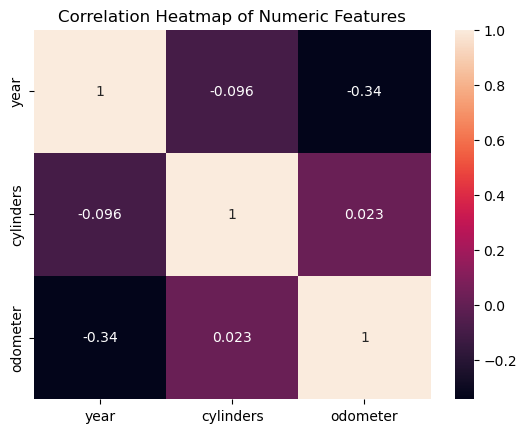

In [115]:
# Correlation heatmap
hMap = sns.heatmap(num_df.corr(), annot = True)
hMap.axes.set_title('Correlation Heatmap of Numeric Features')
hMap.get_figure().savefig('images/CorrHeatmap.png')

#### Observation
The numeric features are not highly correlated with each other. There is a weak negative correlatiion between year and odometer.

### Modeling

It is now time to build some models. We build a couple of different regression models with the price as the target, and cross-validate our findings.

### Data prep for modeling
Independent and depedent variables, training and test datasets

In [116]:
# Target column and independent columns 
x = carsDf.drop('price', axis=1) 
y = carsDf['price']

# split data into train and test set. Train with 70% of the data, validate with 30%
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=32) 
print('Train data size = ', x_train.shape)
print('Test  data size = ', x_test.shape)

Train data size =  (263468, 11)
Test  data size =  (112916, 11)


### Modeling: Ridge model with grid search

In [117]:
# Column transformer: Scale numeric features, OneHotEncode categorical features
column_tf_scaled = make_column_transformer(
    (StandardScaler(), num_feats),
    (OneHotEncoder(), cat_feats),
    verbose_feature_names_out=False
)
column_tf_scaled

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['year', 'cylinders', 'odometer']),
                                ('onehotencoder', OneHotEncoder(),
                                 ['condition', 'transmission', 'drive', 'size',
                                  'type'])],
                  verbose_feature_names_out=False)

##### Logarithm
We notice that the target variable (price), has a long tail even after removing some outliers, so we will use logarithm of the sale price to get an approx normal distribution. This will be done by setting the func argument in the TransformedTargetRegressor below.

In [118]:
# Grid serach with TransformedTargetRegressor and Ridge model
my_estimator = TransformedTargetRegressor(regressor = Ridge(max_iter=100, random_state = 32),
                                          func=np.log1p, inverse_func=np.expm1) 

# Search space (alpha values of Ridge): Evenly spaced in log space
alphas = np.logspace(-5, 5, 20)
alpha_grid = {'regressor__alpha': alphas}

grid_cv_TTR = GridSearchCV(
    estimator = my_estimator,
    param_grid = alpha_grid,
    scoring='neg_mean_squared_error')
grid_cv_TTR

GridSearchCV(estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                  inverse_func=<ufunc 'expm1'>,
                                                  regressor=Ridge(max_iter=100,
                                                                  random_state=32)),
             param_grid={'regressor__alpha': array([1.00000000e-05, 3.35981829e-05, 1.12883789e-04, 3.79269019e-04,
       1.27427499e-03, 4.28133240e-03, 1.43844989e-02, 4.83293024e-02,
       1.62377674e-01, 5.45559478e-01, 1.83298071e+00, 6.15848211e+00,
       2.06913808e+01, 6.95192796e+01, 2.33572147e+02, 7.84759970e+02,
       2.63665090e+03, 8.85866790e+03, 2.97635144e+04, 1.00000000e+05])},
             scoring='neg_mean_squared_error')

In [119]:
# Pipeline: transform columns, then perform grid search
grid_search_pipe1 = Pipeline(steps=[
    ('preprocessor', column_tf_scaled),
    ('grid_search', grid_cv_TTR)
])

grid_search_pipe1

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['year', 'cylinders',
                                                   'odometer']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['condition', 'transmission',
                                                   'drive', 'size', 'type'])],
                                   verbose_feature_names_out=False)),
                ('grid_search',
                 GridSearchCV(estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                                   inverse_func=...
                              param_grid={'regressor__alpha': array([1.00000000e-05, 3.35981829e-05, 1.12883789e-04, 3.79269019e-04,
       1.27427499e-03, 4.28133240e-03, 1.43844989e-02, 4.83293024e-02,
       1.62377674e-01, 5.45559478e-01, 1.83298071e+00, 6.15848211e+00,
       2.06913808e+01, 6.95192796e+01, 2.33572147e+02, 7.84759970e+02,
       2.63665090e+03, 8.85866790e+03, 2.97635144e+04, 1.00000000e+05])},
                              scoring='neg_mean_squared_error'))])

#### Train the model

In [120]:
# Train the model on the training data
grid_search_pipe1.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['year', 'cylinders',
                                                   'odometer']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['condition', 'transmission',
                                                   'drive', 'size', 'type'])],
                                   verbose_feature_names_out=False)),
                ('grid_search',
                 GridSearchCV(estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                                   inverse_func=...
                              param_grid={'regressor__alpha': array([1.00000000e-05, 3.35981829e-05, 1.12883789e-04, 3.79269019e-04,
       1.27427499e-03, 4.28133240e-03, 1.43844989e-02, 4.83293024e-02,
       1.62377674e-01, 5.45559478e-01, 1.83298071e+00, 6.15848211e+00,
       2.06913808e+01, 6.95192796e+01, 2.33572147e+02, 7.84759970e+02,
       2.63665090e+03, 8.85866790e+03, 2.97635144e+04, 1.00000000e+05])},
                              scoring='neg_mean_squared_error'))])

#### Extract the best model and feature coefficients
Recall that the bigger the Ridge coefficient, the more the corresponding feature affects the target variable (sale price). <br/>
Positive coefficients indicate an in sale price, while negative coeffieicents indicate a decrease in price.

In [121]:
best_model1 = grid_search_pipe1.named_steps['grid_search'].best_estimator_
print(best_model1)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Ridge(alpha=784.7599703514607,
                                           max_iter=100, random_state=32))


In [122]:
feature_names1 = grid_search_pipe1.named_steps['preprocessor'].get_feature_names_out()

#print the coefficients in descending order along with the feature names for the best model
coefficients1 = grid_search_pipe1.named_steps['grid_search'].best_estimator_.regressor_.coef_

coefficients_df1 = pd.DataFrame({'feature' : feature_names1, 'coefficient': coefficients1})
coefficients_df1.sort_values(by = 'coefficient', ascending = False, inplace = True)
coefficients_df1 = coefficients_df1.reset_index().drop('index', axis=1)

In [123]:
print(best_model1.get_params())

{'check_inverse': True, 'func': <ufunc 'log1p'>, 'inverse_func': <ufunc 'expm1'>, 'regressor__alpha': 784.7599703514607, 'regressor__copy_X': True, 'regressor__fit_intercept': True, 'regressor__max_iter': 100, 'regressor__positive': False, 'regressor__random_state': 32, 'regressor__solver': 'auto', 'regressor__tol': 0.0001, 'regressor': Ridge(alpha=784.7599703514607, max_iter=100, random_state=32), 'transformer': None}


In [124]:
coefficients_df1

,feature,coefficient
0,type_truck,0.368163
1,type_pickup,0.319402
2,year,0.234383
3,condition_excellent,0.186577
4,condition_like new,0.157118
5,condition_good,0.155494
6,drive_4wd,0.091547
7,cylinders,0.089986
8,transmission_other,0.071519
9,type_convertible,0.068315


#### Most important desirable and undesirable features

In [125]:
# Get the features with the larger coefficients; these are the most important desirable and undesirable traits
# We select features whose coefficients are at least 30% of the largest positive and negative coefficients
maxPosCoeff = np.max(coefficients_df1['coefficient'])
maxNegCoeff = np.min(coefficients_df1['coefficient'])

# Desirable features
coeffs_pos_importance = coefficients_df1[(coefficients_df1['coefficient'] > 0) & 
                                      (coefficients_df1['coefficient'] >= 0.3*maxPosCoeff)]
coeffs_pos_importance

,feature,coefficient
0,type_truck,0.368163
1,type_pickup,0.319402
2,year,0.234383
3,condition_excellent,0.186577
4,condition_like new,0.157118
5,condition_good,0.155494


#### Plot of the most important desirable features

In [126]:
pFig1 = px.bar(coeffs_pos_importance, x = 'feature', y = 'coefficient', color = 'feature',
                labels = {
                     "feature": "Feature",
                     "coefficient": "Importance",
                     "feature": "Feature"
                 })
pFig1.update_layout(
            title={
            'text' : 'Desirable Features',
            'x':0.5,
            'xanchor': 'center'
        })
pFig1.show()

In [127]:
# undesirable features
coeffs_neg_importance = coefficients_df1[(coefficients_df1['coefficient'] < 0) & (coefficients_df1['coefficient'] <= 0.2*maxNegCoeff)]
coeffs_neg_importance = coeffs_neg_importance.sort_values(by = 'coefficient', ascending = True)
coeffs_neg_importance

,feature,coefficient
31,odometer,-0.398423
30,condition_fair,-0.320814
29,type_hatchback,-0.254936
28,condition_salvage,-0.238440
27,type_sedan,-0.218277
26,type_mini-van,-0.192098
25,drive_fwd,-0.159841
24,type_wagon,-0.129921
23,transmission_automatic,-0.087935


#### Plot of the most important undesirable features

In [128]:
pFig2 = px.bar(coeffs_neg_importance, x = 'feature', y = 'coefficient', color = 'feature',
               labels = {
                         "feature": "Feature",
                         "coefficient": "Importance",
                         "feature": "Feature"
                        })
pFig2.update_layout(
            title={
            'text' : 'Undesirable Features',
            'x':0.5,
            'xanchor': 'center'
        })
pFig2.show()

In [129]:
# Estimate prediction quality using MSE
print(f"Pipe1 Train MSE: {mean_squared_error(y_train, grid_search_pipe1.predict(x_train))}")
print(f"Pipe1 Test  MSE: {mean_squared_error(y_test, grid_search_pipe1.predict(x_test))}")

Pipe1 Train MSE: 110365961.2295098
Pipe1 Test  MSE: 108853105.70321234


In [130]:
y_pred1 =grid_search_pipe1.predict(x_test)
print(f'Test data  min price, max price = {np.min(y_test), np.max(y_test)}')
print(f'Prediction min price, max price = {np.min(y_pred1), np.max(y_pred1)}')


Test data  min price, max price = (500, 100000)
Prediction min price, max price = (181.8850752499185, 62576.75030736201)


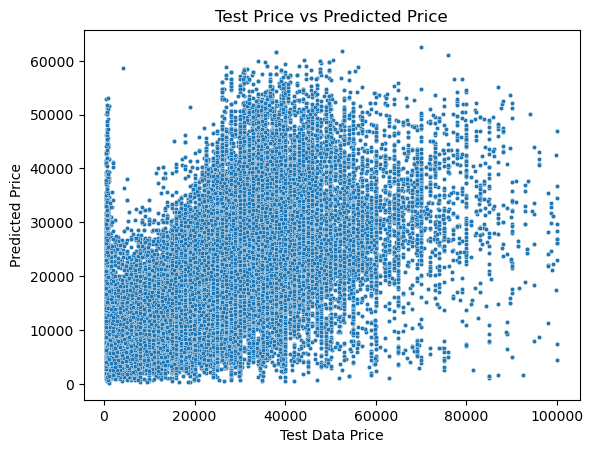

In [131]:
# Scatterplot of test price vs predicted price
sFig1 = sns.scatterplot(x = y_test, y = y_pred1, s = 10)
sFig1.axes.set_xlabel('Test Data Price')
sFig1.axes.set_ylabel('Predicted Price')
sFig1.axes.set_title('Test Price vs Predicted Price')
sFig1.get_figure().savefig('images/TestVsPredictedPrice.png')

### LASSO selector
We also build a LASSO selector to select the 10 most important features (positive or negative) to verify that the ridge model fidings above are reasonable. We run the LASSO selector along with the Ridge model (with grid search for the alpha hyperparameter) as earlier.

In [132]:
lasso_pipe = Pipeline(steps=[
    ('preprocessor', column_tf_scaled),
    ('selector', RFE(Lasso(), n_features_to_select = 10)),
    ('grid_search', grid_cv_TTR)
])
lasso_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['year', 'cylinders',
                                                   'odometer']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['condition', 'transmission',
                                                   'drive', 'size', 'type'])],
                                   verbose_feature_names_out=False)),
                ('selector', RFE(estimator=Lasso(), n_features_to_select=10)),
                ('grid_search',
                 GridSearchCV(estimator=...
                              param_grid={'regressor__alpha': array([1.00000000e-05, 3.35981829e-05, 1.12883789e-04, 3.79269019e-04,
       1.27427499e-03, 4.28133240e-03, 1.43844989e-02, 4.83293024e-02,
       1.62377674e-01, 5.45559478e-01, 1.83298071e+00, 6.15848211e+00,
       2.06913808e+01, 6.95192796e+01, 2.33572147e+02, 7.84759970e+02,
       2.63665090e+03, 8.85866790e+03, 2.97635144e+04, 1.00000000e+05])},
                              scoring='neg_mean_squared_error'))])

In [133]:
# Train the model on the training data
lasso_pipe.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['year', 'cylinders',
                                                   'odometer']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['condition', 'transmission',
                                                   'drive', 'size', 'type'])],
                                   verbose_feature_names_out=False)),
                ('selector', RFE(estimator=Lasso(), n_features_to_select=10)),
                ('grid_search',
                 GridSearchCV(estimator=...
                              param_grid={'regressor__alpha': array([1.00000000e-05, 3.35981829e-05, 1.12883789e-04, 3.79269019e-04,
       1.27427499e-03, 4.28133240e-03, 1.43844989e-02, 4.83293024e-02,
       1.62377674e-01, 5.45559478e-01, 1.83298071e+00, 6.15848211e+00,
       2.06913808e+01, 6.95192796e+01, 2.33572147e+02, 7.84759970e+02,
       2.63665090e+03, 8.85866790e+03, 2.97635144e+04, 1.00000000e+05])},
                              scoring='neg_mean_squared_error'))])

In [134]:
best_model2 = lasso_pipe.named_steps['grid_search'].best_estimator_
print(best_model2)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Ridge(alpha=69.51927961775606,
                                           max_iter=100, random_state=32))


In [135]:
#seqSelector = lasso_pipe.named_steps['selector']
lasso_feats = lasso_pipe[:-1].get_feature_names_out()
lasso_feats

array(['year', 'odometer', 'condition_salvage', 'drive_fwd',
       'type_hatchback', 'type_mini-van', 'type_pickup', 'type_sedan',
       'type_truck', 'type_wagon'], dtype=object)

In [136]:
coefficients2 = lasso_pipe.named_steps['grid_search'].best_estimator_.regressor_.coef_
coefficients2

array([ 0.23417733, -0.42919441, -0.64245104, -0.27158211, -0.24327281,
       -0.21182852,  0.41569446, -0.21917995,  0.45210232, -0.13894495])

In [137]:
coefficients_df2 = pd.DataFrame({'feature' : lasso_feats, 'coefficient': coefficients2})
coefficients_df2.sort_values(by = 'coefficient', ascending = False, inplace = True)
coefficients_df2 = coefficients_df2.reset_index().drop('index', axis=1)

In [138]:
coefficients_df2

,feature,coefficient
0,type_truck,0.452102
1,type_pickup,0.415694
2,year,0.234177
3,type_wagon,-0.138945
4,type_mini-van,-0.211829
5,type_sedan,-0.219180
6,type_hatchback,-0.243273
7,drive_fwd,-0.271582
8,odometer,-0.429194
9,condition_salvage,-0.642451


In [139]:
# Estimate prediction quality using MSE
print(f"Pipe1 Train MSE: {mean_squared_error(y_train, lasso_pipe.predict(x_train))}")
print(f"Pipe1 Test  MSE: {mean_squared_error(y_test, lasso_pipe.predict(x_test))}")

y_pred_lasso =lasso_pipe.predict(x_test)
print(f'Test data  min price, max price = {np.min(y_test), np.max(y_test)}')
print(f'Prediction min price, max price = {np.min(y_pred_lasso), np.max(y_pred_lasso)}')


Pipe1 Train MSE: 109801290.29423842
Pipe1 Test  MSE: 108255552.04926245
Test data  min price, max price = (500, 100000)
Prediction min price, max price = (201.86564937221289, 57088.98032422863)


Text(0.5, 1.0, 'Test Price vs Predicted Price')

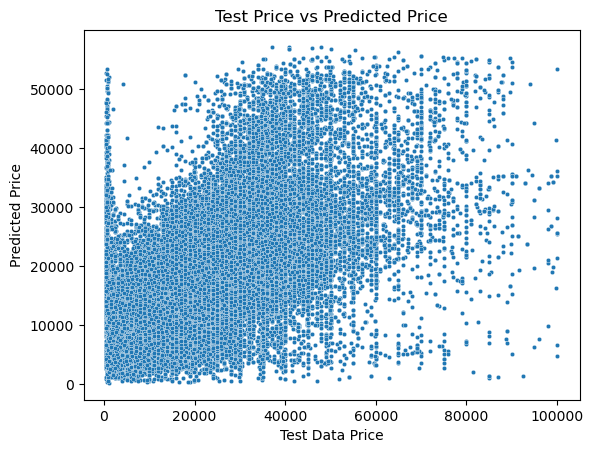

In [140]:
sFig2 = sns.scatterplot(x = y_test, y = y_pred_lasso, s = 10)
sFig2.axes.set_xlabel('Test Data Price')
sFig2.axes.set_ylabel('Predicted Price')
sFig2.axes.set_title('Test Price vs Predicted Price')

### Evaluation

#### Observation on LASSO selector results
We note that the LASSO selector produced very similar results to the earlier Ridge model, further validating the Ridge results. Since the test vs predicted scatterplot for LASSO is not as symmetric about the 45 degree line as the Ridge model, we will use the Ridge results to draw conclusions and recommendations.

### Recommendations

Based on the results of our Machine Learning model, we can now make some recommendations to car dealers. Some of these recommendations are probably expected from past experience, but we are also able provide some possibly new insights that we have uncovered.

#### The most important *desirable* features

These are the features that contribute most to increased sale value of a vehicle. <br/>

- <b> Condition </b> (New, excellent, good).
- <b> Model Year.</b> The later the model year, the more buyers are willing to pay for the vehicle.
- <b> Certain Vehicle Types </b> (pickup trucks!) 

In [141]:
#px.bar(x = coeffs_df1_pos_imp['feature'], y = coeffs_df1_pos_imp['coefficient'])
pFig1.show()

#### The most important *undesirable* features

These are the features that contribute to the highest decrease in sale value of a vehicle. <br/>

- <b> Odometer (mileage) </b> The higher the mileage of the vehicle, the less buyers are willing to pay. We note that there is only a mild negative correlation between model year and odometer, so the undesirability of high mileage goes beyond mere correlation with model year.
- <b> Condition </b> (salvage, fair). We note that even fair condition is not acceptable to buyers, perhaps because of 'condition padding' by sellers
- <b> Certain Vehicle Types </b> (hatchbacks, minivans, sedans, station wagons)

In [142]:
# Correlation between model year and odometer (we expect some negative correlation)
print('Correlation between model year and odometer = ', carsDf['year'].corr(carsDf['odometer']))

Correlation between model year and odometer =  -0.3417600098600698


In [143]:
#px.bar(x = coeffs_df1_neg_imp['feature'], y = coeffs_df1_neg_imp['coefficient'])
pFig2.show()

### SUVs
While SUVs are the highest-selling *new* cars, we note that they are neither strongly desirable or undesirable in the *used* car market. 

### Next Steps
Now that we have a good understanding of the important features that drive used car price, It will be useful to see if the inclusion of some of the dropped features, notably manufacturer, has an effect on the price.